---
title       : "Machine Learning in Julia"
subtitle    :
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "../ml.bib"
options:
      out_width : 100%
      wrap : true
      fig_width : 800
      dpi : 192
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](ml-julia.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"  
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"


using NeuralNetworkEconomics
docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs")

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

Activating environment at `~/.julia/dev/NeuralNetworkEconomics/docs/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Introduction

This document is a companion to my ["Machine learning in
economics"](ml-intro.md). Those notes discuss the recent use of
machine learning in economics, with a focus on lasso and random
forests. The code in those notes is written in R. This document will
look at similar code in Julia.

# RCall

If you want to use the methods of Chernozhukov and coauthors
implements in the R packaga @hdm or the methods of Athey and coauthors
implemented in the R package @grf , then it makes sense to use the R
pacakge. You could simply write all your code in R. However, if you
prefer using Julia, you can just call the necessary R functions with
[`RCall.jl`](https://github.com/JuliaInterop/RCall.jl). 


Here, we load the pipeline data used in the [machine
learning methods notes](ml-methods.md), and do some cleaning in Julia.

In [2]:
using RCall, DataFrames, Missings, Statistics
R"load(paste($(docdir),\"/rmd/pipelines.Rdata\",sep=\"\"))"
println(R"ls()")
data = @rget data # data on left is new Julia variable, data on right is the one in R
println(R"summary(data[,1:5])")
println(describe(data[:,1:5]))
for c in 59:107 # columns of state mileage, want missing->0
  replace!(x->(ismissing(x) || isnan(x)) ? 0.0 : x, data[!,c])
end
println(describe(data[:,59:65]))

RObject{StrSxp}
[1] "#JL"  "data"

RObject{StrSxp}
 respondent_id     report_yr      report_prd     major        
 Min.   :  1.0   Min.   :1991   Min.   :12     Mode :logical  
 1st Qu.: 64.0   1st Qu.:1997   1st Qu.:12     FALSE:1192     
 Median :148.0   Median :2003   Median :12     TRUE :2797     
 Mean   :184.3   Mean   :2003   Mean   :12     NA's :2180     
 3rd Qu.:214.0   3rd Qu.:2010   3rd Qu.:12                    
 Max.   :745.0   Max.   :2016   Max.   :12                    
                                NA's   :3371                  
                             respondent_name
 Centra Pipelines Minnesota Inc.     :  22  
 Tuscarora Gas Transmission Company  :  22  
 Eastern Shore Natural Gas Company   :  22  
 Kern River Gas Transmission Company :  21  
 National Fuel Gas Supply Corporation:  21  
 (Other)                             :2938  
 NA's                                :3123  

5×8 DataFrame
│ Row │ variable        │ mean     │ min                              

Suppose we want to estimate the coefficient on `transPlant` (capital)
in a partially linear model with `transProfit` (profit) as the
outcome. This can be done with the R function `hdm::rlassoEffects`.

In [3]:
R"library(hdm)"
completedata = dropmissing(data,[1:10..., 59:122...], disallowmissing=true)
y = completedata[:transProfit]
inc = .!isnan.(y)
y = y[inc]
X = completedata[inc,[6:7..., 59:121...]]
cols = [std(X[c])>0 for c in 1:ncol(X)]
X = X[:,cols]
est = R"rlassoEffects($(X), $(y), index=c(1:2))"
R"summary($est)"

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:3
└ @ Core In[3]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = (::getfield(Main, Symbol("##5#6")))(::Int64) at none:0
└ @ Main ./none:0


RObject{VecSxp}
[1] "Estimates and significance testing of the effect of target variables"
                      Estimate. Std. Error t value Pr(>|t|)    
transPlant_bal_end_yr  0.034434   0.008878   3.879 0.000105 ***
transPlant_bal_beg_yr  0.086580   0.009383   9.228  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




# MLJ.jl

[`MLJ.jl`](https://github.com/alan-turing-institute/MLJ.jl) is a machine
learning framework for Julia. It gives a unified interface for many
machine learning algorithms and tasks. Similar R packages include
`caret` and `MLR`. [`scikit-learn`](https://scikit-learn.org/stable/)
is a similar Python package. 

For more information on MLJ see 

- [`MLJ.jl docs`](https://alan-turing-institute.github.io/MLJ.jl/stable/)

- [MLJ
  tutorials](https://alan-turing-institute.github.io/MLJTutorials/)

You can see a list of models registered to work with `MLJ.jl` on
[github](https://github.com/alan-turing-institute/MLJModels.jl/blob/master/src/registry/Models.toml),
or by calling `MLJ::models()`.

In [4]:
using MLJ
models()

109-element Array{NamedTuple,1}:
 (name = ARDRegressor, package_name = ScikitLearn, ... )             
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )       
 (name = AdaBoostRegressor, package_name = ScikitLearn, ... )        
 (name = BaggingClassifier, package_name = ScikitLearn, ... )        
 (name = BaggingRegressor, package_name = ScikitLearn, ... )         
 (name = BayesianLDA, package_name = MultivariateStats, ... )        
 (name = BayesianLDA, package_name = ScikitLearn, ... )              
 (name = BayesianQDA, package_name = ScikitLearn, ... )              
 (name = BayesianRidgeRegressor, package_name = ScikitLearn, ... )   
 (name = BernoulliNBClassifier, package_name = ScikitLearn, ... )    
 (name = ComplementNBClassifier, package_name = ScikitLearn, ... )   
 (name = ConstantClassifier, package_name = MLJModels, ... )         
 (name = ConstantRegressor, package_name = MLJModels, ... )          
 ⋮                                                       

To use these models, you need the corresponding package to be
installed and loaded. The `@load` macro will load the needed package(s)
for any model.

In [5]:
lasso_model = @load LassoRegressor pkg=MLJLinearModels

LassoRegressor(lambda = 1.0,
               fit_intercept = true,
               penalize_intercept = false,
               solver = nothing,) @ 8…06

Let's fit lasso to the same pipeline data as above.

In [6]:
lasso_model.lambda = 1.0
lasso = machine(lasso_model, X, y)
train,test = partition(eachindex(y), 0.6, shuffle=true)
fit!(lasso, rows=train)
yhat = predict(lasso, rows=test)
println(yhat[1:10])
println("MSE/var(y) = $(mean((y[test].-yhat).^2)/var(y[test]))")

┌ Info: Training Machine{LassoRegressor} @ 8…77.
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/machines.jl:141
┌ Warning: No appropriate stepsize found via backtracking; interrupting.
└ @ MLJLinearModels /home/paul/.julia/packages/MLJLinearModels/PYnvA/src/fit/proxgrad.jl:49
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /home/paul/.julia/packages/MLJLinearModels/PYnvA/src/fit/proxgrad.jl:62


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MSE/var(y) = 1.481910899807435


That doesn't look very good. All the predictions are zero. This could
happen when the regularization parameter, `lambda`, is too
large. However, in this case the problem is something else. The
warning messages indicate numeric problems when minimizing the lasso
objective function. This can happen when `X` is poorly scaled. The
algorithm used to compute the lasso estimates works best when the
coefficients are all roughly the same scale. The existing `X`'s have
wildly different scales, which causes problems. This situation is
common, so `MLJ.jl` has functions to standardize variables. It is
likely that the `hdm` package in R does something similar internally.

In [7]:
lasso_stdx = @pipeline PipeLasso(std=Standardizer(),
                  lasso=LassoRegressor(lambda=1.0*std(y),
                                       solver=MLJLinearModels.ISTA(max_iter=10000)
                                       )
                                 )
m = machine(lasso_stdx, X, y)
fit!(m, rows=train)
yhat = predict(m , rows=test)
println("MSE/var(y) = $(mean((y[test].-yhat).^2)/var(y[test]))")

# Get the fitted coefficients
coef = fitted_params(m).fitted_params[1].coefs
intercept = fitted_params(m).fitted_params[1].intercept
sum(abs.(coef).>1e-8) # number non-zero

┌ Info: Training Machine{PipeLasso} @ 1…44.
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/machines.jl:141
┌ Info: Training NodalMachine{Standardizer} @ 4…33.
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/machines.jl:141
┌ Info: Training NodalMachine{LassoRegressor} @ 3…52.
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/machines.jl:141


MSE/var(y) = 0.12774400474495795


55

If we want to tune `lambda` using cross-validation, we can use the
`range` and `TunedModel` functions.

In [8]:
r = range(lasso_stdx, :(lasso.lambda), lower=1e1, upper=1e10, scale=:log)
t=TunedModel(model=lasso_stdx,
             resampling=CV(nfolds=5),
             tuning=Grid(resolution=10), 
             ranges=r,
             measure=rms)
m = machine(t, X, y)
fit!(m, rows=train, verbosity=1)
yhat = predict(m , rows=test)
println("MSE/var(y) = $(mean((y[test].-yhat).^2)/var(y[test]))")

┌ Info: Training Machine{DeterministicTunedModel} @ 7…01.
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/machines.jl:141
┌ Info: Mimimizing rms. 
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/tuning.jl:195
Iterating over a 10-point grid: 100%[=========================] Time: 0:00:20
┌ Info: Training best model on all supplied data.
└ @ MLJ /home/paul/.julia/packages/MLJ/BEVGY/src/tuning.jl:288


MSE/var(y) = 0.12012601515477671


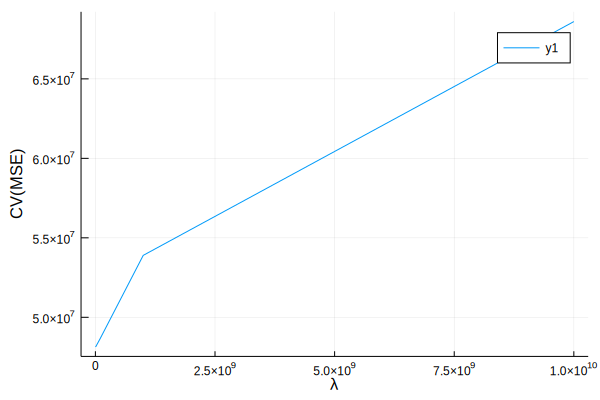

In [9]:
using Plots
cvmse = m.report.measurements
λ = Float64.(m.report.parameter_values[:])
plot(λ, cvmse, xlab="λ", ylab="CV(MSE)")

# Flux.jl 

[`Flux.jl`](https://fluxml.ai/Flux.jl/stable/) is another Julia
package for machine learning. It seems to be emerging as the leading
Julia package for neural networks and deep learning, but other machine
learning models can also be implemented using `Flux.jl`. 

Let's create a lasso model in `Flux.jl`.

loss(X_train, y_train) = 1.029254474385926 (tracked)


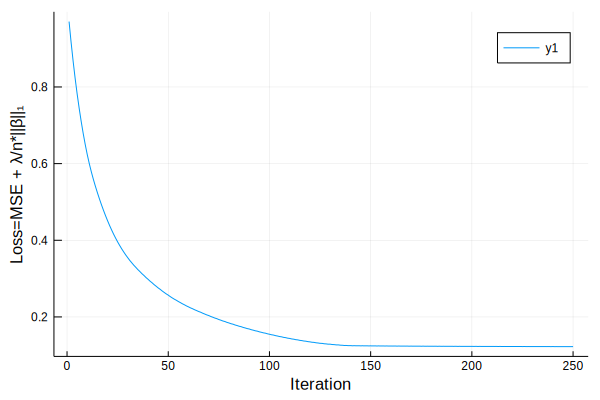

In [10]:
using Flux, LinearAlgebra
# Scale the variables
Xstd = Flux.normalise(Matrix(X))
X_train = Xstd[train,:]
X_test = Xstd[test,:]
yscale = std(y)
ymean = mean(y)
ystd = (y .- ymean)./yscale
y_train = ystd[train]
y_test = ystd[test]

# Set up the model parameters and initial values
βols = (X_train'*X_train) \ (X_train'*(y_train .- mean(y_train)))
β = param(zeros(ncol(X))) #βols) #zeros(ncol(X)))
b = param([mean(y_train)])
θ = Tracker.Params([β,b])

# Define the loss function
ψ = ones(length(β))
λ = 2.0
pred(x) = b .+ x*β
mse(x,y) = mean( (pred(x) .- y).^2 )
penalty(y) = λ/length(y)*norm(ψ.*β,1)
loss(x,y) =  mse(x,y) + penalty(y)
@show loss(X_train,y_train)

# minimize loss
maxiter=2000
obj = zeros(maxiter)
mse_train = zeros(maxiter)
mse_test = zeros(maxiter)
for i in 1:maxiter
  Flux.train!(loss, θ, [(X_train, y_train)], Flux.AMSGrad())
  mse_train[i] = Tracker.data(mse(X_train,y_train))
  mse_test[i] = Tracker.data(mse(X_test, y_test))
  obj[i] = Tracker.data(loss(X_train,y_train))
end
lo = 1
hi = 250
plot(obj[lo:hi], ylab="Loss=MSE + λ/n*||β||₁", xlab="Iteration")

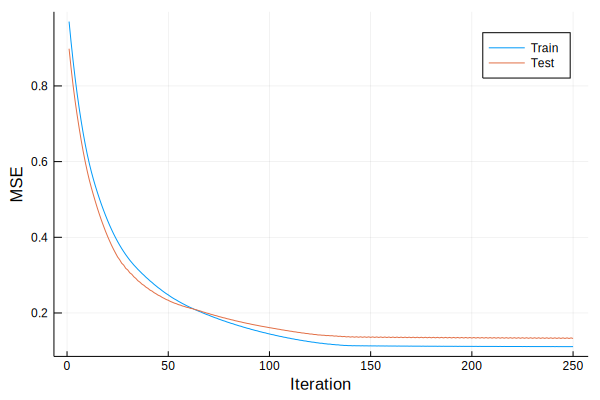

In [11]:
plot(lo:hi, [mse_train[lo:hi] mse_test[lo:hi]], ylab="MSE", xaxis=("Iteration")
     , lab=["Train" "Test"])

The minimization methods in `Flux.train!` are all variants of gradient
descent. Each call to `Flux.train!` runs one iteration of the
specified solver. To find a locaol minimum, `Flux.train!` can be
called repeatedly until progress stops. The above loop is a simple way
to do this. The `@epoch` macro can also be useful. 

Gradient descent works well for neural networks, but is not ideal for
Lasso. Without further adjustment, gradient descent gets stuck in a
cycle as jumps from one side of the other of the absolute value in the
lasso penalty. Nonetheless, the results are near the true minimum,
even though it never exactly gets there. 


# Additional Resources

- @klok2019 *Statistics with Julia:Fundamentals for Data Science,
  MachineLearning and Artificial Intelligence*
  

# References